In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
malgenome_all = pd.read_csv('malgenome.csv')

In [3]:
#dataset load
malgenome_permissions = pd.read_csv('malgenome.csv', 
                         usecols= [5,7,13,15,16,23,25,33,34,38,39,42,43,47,48,49,51,
                                   55,58,61,64,66,67,68,72,*range(76, 85),86,
                                  89,92,96,99,100,103,*range(105,110),111,112,
                                  116,118,119,*range(121,126),127,129,130,
                                  *range(132,138),139,142,143,144,*range(147,155),
                                  158,162,163,164,167,169,170,171,173,174,175,178,
                                  *range(180,186),187,*range(189,193),195,199,
                                  200,202,204,205,*range(207,214)])

In [4]:
malgenome_permissions.head()

,READ_SMS,WRITE_SMS,READ_PHONE_STATE,GET_ACCOUNTS,SEND_SMS,WRITE_APN_SETTINGS,RECEIVE_SMS,USE_CREDENTIALS,MANAGE_ACCOUNTS,RESTART_PACKAGES,...,MODIFY_PHONE_STATE,READ_INPUT_STATE,READ_EXTERNAL_STORAGE,SET_ORIENTATION,DEVICE_POWER,EXPAND_STATUS_BAR,GET_TASKS,GLOBAL_SEARCH,GET_PACKAGE_SIZE,SET_PREFERRED_APPLICATIONS
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,1,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [5]:
malgenome_all.shape

(3799, 216)

In [6]:
malgenome_permissions.shape

(3799, 113)

In [7]:
X_all = malgenome_all.iloc[0:,0:215]  #independent columns
y_all = malgenome_all.iloc[0:,-1]
X_all["TelephonyManager.getSimCountryIso"] = pd.to_numeric(X_all['TelephonyManager.getSimCountryIso'], errors='coerce').fillna(0).astype(int)

In [8]:
#malgenome_all.info()
X_permissions = malgenome_permissions.iloc[0:,0:113]  #independent columns
y_permissions = malgenome_permissions.iloc[0:,-1]
#X_permissions["TelephonyManager.getSimCountryIso"] = pd.to_numeric(X_permissions['TelephonyManager.getSimCountryIso'], errors='coerce').fillna(0).astype(int)

In [9]:
y_all = y_all.map(dict(S=1, B=0))

In [10]:
y_all

0       1
1       1
2       1
3       1
4       1
       ..
3794    0
3795    0
3796    0
3797    0
3798    0
Name: class, Length: 3799, dtype: int64

In [64]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X_permissions, y_all, test_size = 0.5, random_state = 0)


In [12]:
#mandatory import 
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


from sklearn.feature_selection import RFE

In [30]:
with_corr=[]
without_corr=[]
pre = []
rec = []
fs = []
acc = []
auc = []
def clear_metrics(): 
    with_corr.clear()
    without_corr.clear()
    pre.clear()
    rec.clear()
    fs.clear()
    acc.clear()
    auc.clear()

In [50]:
import csv, os, time 
def results_to_csv(title, corr=0):
    directory = "PERMISSIONS_CSV"
  
    # Parent Directory path 
    parent_dir = os.getcwd()
    print(parent_dir)
    
#     if not parent_dir == 'Malgenome':
#         os.chdir('Malgenome')
#         parent_dir = os.getcwd()
#         print(parent_dir)
  
    # Path 
    path = os.path.join(parent_dir, directory) 
    if not os.path.exists('PERMISSIONS_CSV'):
        os.mkdir(path)
    os.chdir(path) 
    print(1)
    with open(title+ '.csv', 'w') as f:
        writer = csv.writer(f)
        if corr==1: 
            writer.writerow(['Without Correlation', 'With Correlation','Accuracy','Precision', 'Recall', 'F1','AUC'])
            writer.writerows(zip(without_corr, with_corr, acc, pre, rec, fs, auc))
            print(without_corr, with_corr, acc, pre, rec, fs, auc)
        else: 
            writer.writerow(['Accuracy','Precision', 'Recall', 'F1','AUC'])
            
            writer.writerows(zip(acc, pre, rec, fs, auc))
    os.chdir('../')
        
def allscore(scores,i,with_correlation=0):
    without_corr.insert(i,i)
    if with_correlation!=0:
        with_corr.insert(i,with_correlation)
    acc.insert(i,scores['test_accuracy'].mean())
    fs.insert(i,scores['test_f1'].mean())
    pre.insert(i,scores['test_precision'].mean())
    rec.insert(i,scores['test_recall'].mean())
    auc.insert(i,scores['test_roc_auc'].mean())
    print("Accuracy: %0.4f   (+/- %0.4f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("Precision: %0.4f   (+/- %0.4f)" % (scores['test_precision'].mean(), scores['test_accuracy'].std() * 2))
    print("Recall: %0.4f   (+/- %0.4f)" % (scores['test_recall'].mean(), scores['test_accuracy'].std() * 2))
    print("F-1 Score: %0.4f   (+/- %0.4f)" % (scores['test_f1'].mean(), scores['test_accuracy'].std() * 2))
    print("ROC-AUC: %0.4f   (+/- %0.4f)" % (scores['test_roc_auc'].mean(), scores['test_accuracy'].std() * 2))
def run_randomForest(X,y, i=0, with_corr=0):
    scoring = ['precision', 'recall', 'f1','accuracy','roc_auc']
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    scores = cross_validate(clf, X, y, cv=10, n_jobs=-1,
                        scoring=scoring, return_train_score=False)
    print('Classification Report for Random Forest:   ', i)
    allscore(scores,i,with_corr)
def incremental_plot(i,j,title, x_axis = "Number of Permissions"): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = pre
    y2 = rec
    y3 = acc
    y4 = fs

    fig = plt.figure()
    ax = plt.subplot(111)
    #savefig('f.png', bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("Performance Metrics")
    ax.plot(x,y1, mew = 1, label='Precision') #mew = marker width
    ax.plot(x,y2,  mew = 1, label='Recall') #mew = marker width
    ax.plot(x,y3,  mew = 1, label='Accuracy') #mew = marker width
    ax.plot(x,y4, mew = 1, label='F-1 Score') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)
    directory = "PERMISSIONS_FIGURES"
  
    # Parent Directory path 
    parent_dir = os.getcwd()
  
    # Path 
    path = os.path.join(parent_dir, directory) 
    if not os.path.exists('PERMISSIONS_FIGURES'):
        os.mkdir(path)
    os.chdir(path) 
    plt.savefig(title + '.png', bbox_inches='tight', pad_inches=.1)
    os.chdir('../')
    
def incremental_plot_auc(i,j,title, x_axis = "Number of Permissions"): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = auc
 

    fig = plt.figure()
    ax = plt.subplot(111)
    #savefig('f.png', bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("ROC-AUC Score")
    ax.plot(x,y1, mew = 1, label='ROC-AUC') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)
    directory = "PERMISSIONS_FIGURES"
  
    # Parent Directory path 
    parent_dir = os.getcwd()
  
    # Path 
    path = os.path.join(parent_dir, directory) 
    if not os.path.exists('PERMISSIONS_FIGURES'):
        os.mkdir(path)
    os.chdir(path) 
    plt.savefig(title + '_AUC.png', bbox_inches='tight', pad_inches=.1)
    os.chdir('../')
    
    
    

In [65]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j])> threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col
def grouped_correlated(X):
    corr_features = get_correlation(X, 0.80)
    #print(corr_features)
    X_uncorrelated = X.drop(labels = corr_features, axis =1)
    corrmat = X.corr()
    corrdata = corrmat.abs().stack()
    corrdata = corrdata.sort_values(ascending=False)
    corrdata = corrdata[corrdata>0.80]
    corrdata = corrdata[corrdata<1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['features1', 'features2', 'corr_value']
    #print(corrdata)
    
   
    top_corr_features = corrmat.index
    #plt.figure(figsize=(24,24))
    #plot heat map
    #g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
#     bottom, top = g.get_ylim()
#     g.set_ylim(bottom + 0.5, top - 0.5)
#     #figure = g.get_figure()    
#     figure.savefig('Correlation', dpi=400, bbox_inches='tight', pad_inches=.1)
    grouped_feature_list = []
    correlated_groups_list = []
    for feature in corrdata.features1.unique():
        if feature not in grouped_feature_list:
            correlated_block = corrdata[corrdata.features1 == feature]
            grouped_feature_list = grouped_feature_list + list(correlated_block.features2.unique()) + [feature]
            correlated_groups_list.append(correlated_block)
    #Feature Importance based on tree based classifiers 

    important_features = []
    for group in correlated_groups_list:
        features = list(group.features1.unique()) + list(group.features2.unique())
        rf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=0)
        rf.fit(X[features], y_validate)

        importance = pd.concat([pd.Series(features), pd.Series(rf.feature_importances_)], axis = 1)
        importance.columns = ['features', 'importance']
        importance.sort_values(by = 'importance', ascending = False, inplace = True)
        feat = importance.iloc[0]
        important_features.append(feat)
    important_features= pd.DataFrame(important_features)
    important_features.reset_index(inplace=True, drop = True)
    important_features
    features_to_consider = set(important_features['features'])
    features_to_discard = set(corr_features) - set(features_to_consider)
    features_to_discard = list(features_to_discard)
    X_grouped_correlated = X.drop(labels = features_to_discard, axis = 1)
    print (X_grouped_correlated.shape)
    return X_grouped_correlated
def to_dataframe(X):
    print(X.shape)
    X_return = pd.DataFrame(data=X,
          index=np.arange(1, X.shape[0]+1), columns=np.arange(1, X.shape[1]+1))
    
    return X_return

## Feature Importance using SelectKBest, chi2, f-score

In [26]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Permissions','Score']  #naming the dataframe columns

In [27]:
clear_metrics()
#X_top_feat_imps
for index in range(1,114,1):
    top_permissions_indexes = []
    top_permissions_indexes = featureScores.Score.nlargest(index).index
    X_top_feat_imps = X_validate.iloc[0:,top_permissions_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7701   (+/- 0.0397)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7745   (+/- 0.0397)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8211   (+/- 0.0588)
Precision: 0.8001   (+/- 0.0588)
Recall: 0.6555   (+/- 0.0588)
F-1 Score: 0.7190   (+/- 0.0588)
ROC-AUC: 0.8102   (+/- 0.0588)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8189   (+/- 0.0514)
Precision: 0.7944   (+/- 0.0514)
Recall: 0.6540   (+/- 0.0514)
F-1 Score: 0.7159   (+/- 0.0514)
ROC-AUC: 0.8211   (+/- 0.0514)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8211   (+/- 0.0466)
Precision: 0.8431   (+/- 0.0466)
Recall: 0.6030   (+

Classification Report for Random Forest:    39
Accuracy: 0.9437   (+/- 0.0236)
Precision: 0.9225   (+/- 0.0236)
Recall: 0.9187   (+/- 0.0236)
F-1 Score: 0.9196   (+/- 0.0236)
ROC-AUC: 0.9790   (+/- 0.0236)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9463   (+/- 0.0257)
Precision: 0.9232   (+/- 0.0257)
Recall: 0.9263   (+/- 0.0257)
F-1 Score: 0.9239   (+/- 0.0257)
ROC-AUC: 0.9802   (+/- 0.0257)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9505   (+/- 0.0254)
Precision: 0.9314   (+/- 0.0254)
Recall: 0.9293   (+/- 0.0254)
F-1 Score: 0.9297   (+/- 0.0254)
ROC-AUC: 0.9813   (+/- 0.0254)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9511   (+/- 0.0267)
Precision: 0.9342   (+/- 0.0267)
Recall: 0.9278   (+/- 0.0267)
F-1 Score: 0.9303   (+/- 0.0267)
ROC-AUC: 0.9806   (+/- 0.0267)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9563   (+/- 0.0262)
Precision: 0.9429   (+/- 0.0262)
Recall: 0.9338   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9616   (+/- 0.0283)
Precision: 0.9576   (+/- 0.0283)
Recall: 0.9323   (+/- 0.0283)
F-1 Score: 0.9445   (+/- 0.0283)
ROC-AUC: 0.9815   (+/- 0.0283)
(1900, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9647   (+/- 0.0216)
Precision: 0.9663   (+/- 0.0216)
Recall: 0.9323   (+/- 0.0216)
F-1 Score: 0.9487   (+/- 0.0216)
ROC-AUC: 0.9817   (+/- 0.0216)
(1900, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9621   (+/- 0.0244)
Precision: 0.9587   (+/- 0.0244)
Recall: 0.9323   (+/- 0.0244)
F-1 Score: 0.9451   (+/- 0.0244)
ROC-AUC: 0.9812   (+/- 0.0244)
(1900, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9626   (+/- 0.0223)
Precision: 0.9616   (+/- 0.0223)
Recall: 0.9308   (+/- 0.0223)
F-1 Score: 0.9457   (+/- 0.0223)
ROC-AUC: 0.9815   (+/- 0.0223)
(1900, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9637   (+/- 0.0197)
Precision: 0.9619   (+/- 0.0197)
Recall: 0.9338   (+/

In [28]:
title = "Feature Selection using SelectKBest(Chi-Square Test)"
results_to_csv(title)

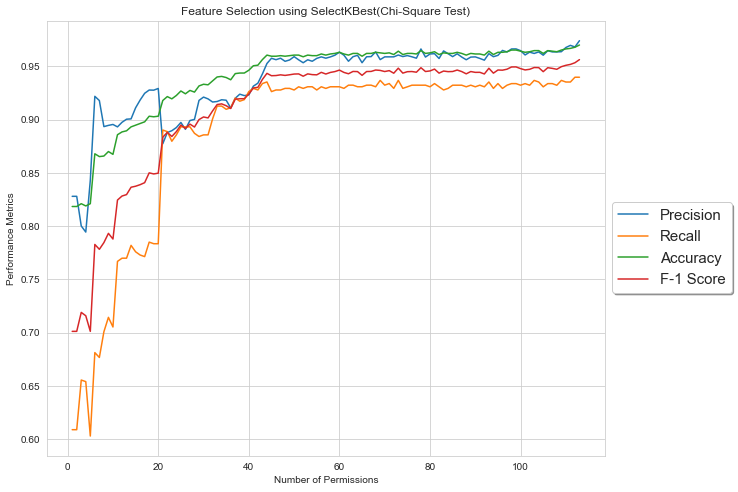

In [29]:
incremental_plot(1,114,title)

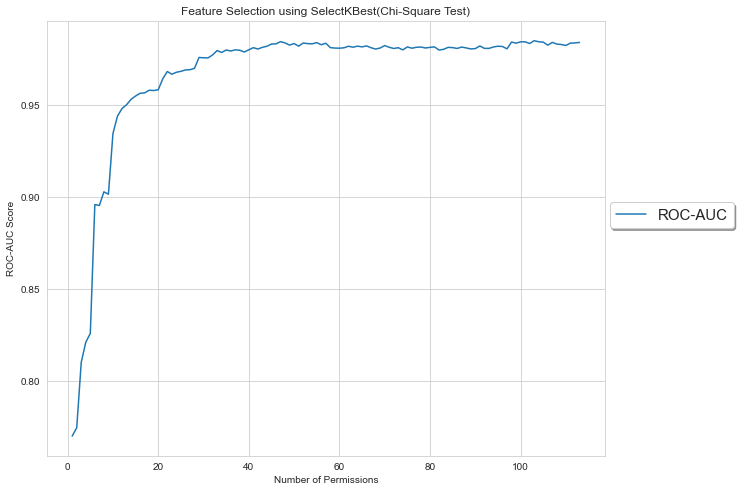

In [30]:
incremental_plot_auc(1,114,title)

In [31]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Permissions','Score']  #naming the dataframe columns

In [64]:
featureScores.Score.nlargest(5).index

Int64Index([0, 1, 3, 2, 4], dtype='int64')

In [32]:
clear_metrics()
#X_top_feat_imps
for index in range(1,114,1):
    top_permissions_indexes = []
    top_permissions_indexes = featureScores.Score.nlargest(index).index
    X_top_feat_imps = X_validate.iloc[0:,top_permissions_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7701   (+/- 0.0397)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7745   (+/- 0.0397)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8211   (+/- 0.0588)
Precision: 0.8001   (+/- 0.0588)
Recall: 0.6555   (+/- 0.0588)
F-1 Score: 0.7190   (+/- 0.0588)
ROC-AUC: 0.8102   (+/- 0.0588)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8279   (+/- 0.0494)
Precision: 0.8256   (+/- 0.0494)
Recall: 0.6465   (+/- 0.0494)
F-1 Score: 0.7245   (+/- 0.0494)
ROC-AUC: 0.8757   (+/- 0.0494)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8247   (+/- 0.0452)
Precision: 0.8180   (+/- 0.0452)
Recall: 0.6436   (+

Classification Report for Random Forest:    39
Accuracy: 0.9547   (+/- 0.0241)
Precision: 0.9428   (+/- 0.0241)
Recall: 0.9277   (+/- 0.0241)
F-1 Score: 0.9349   (+/- 0.0241)
ROC-AUC: 0.9784   (+/- 0.0241)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9547   (+/- 0.0184)
Precision: 0.9411   (+/- 0.0184)
Recall: 0.9293   (+/- 0.0184)
F-1 Score: 0.9349   (+/- 0.0184)
ROC-AUC: 0.9781   (+/- 0.0184)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9558   (+/- 0.0222)
Precision: 0.9456   (+/- 0.0222)
Recall: 0.9277   (+/- 0.0222)
F-1 Score: 0.9363   (+/- 0.0222)
ROC-AUC: 0.9785   (+/- 0.0222)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9547   (+/- 0.0135)
Precision: 0.9453   (+/- 0.0135)
Recall: 0.9248   (+/- 0.0135)
F-1 Score: 0.9347   (+/- 0.0135)
ROC-AUC: 0.9795   (+/- 0.0135)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9589   (+/- 0.0181)
Precision: 0.9514   (+/- 0.0181)
Recall: 0.9308   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9632   (+/- 0.0330)
Precision: 0.9594   (+/- 0.0330)
Recall: 0.9353   (+/- 0.0330)
F-1 Score: 0.9468   (+/- 0.0330)
ROC-AUC: 0.9836   (+/- 0.0330)
(1900, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9637   (+/- 0.0296)
Precision: 0.9619   (+/- 0.0296)
Recall: 0.9338   (+/- 0.0296)
F-1 Score: 0.9473   (+/- 0.0296)
ROC-AUC: 0.9830   (+/- 0.0296)
(1900, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9642   (+/- 0.0297)
Precision: 0.9620   (+/- 0.0297)
Recall: 0.9353   (+/- 0.0297)
F-1 Score: 0.9481   (+/- 0.0297)
ROC-AUC: 0.9830   (+/- 0.0297)
(1900, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9647   (+/- 0.0262)
Precision: 0.9633   (+/- 0.0262)
Recall: 0.9353   (+/- 0.0262)
F-1 Score: 0.9487   (+/- 0.0262)
ROC-AUC: 0.9843   (+/- 0.0262)
(1900, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9637   (+/- 0.0251)
Precision: 0.9605   (+/- 0.0251)
Recall: 0.9353   (+/

In [33]:
title = "Feature Selection using SelectKBest(ANOVA F-value)"
results_to_csv(title)

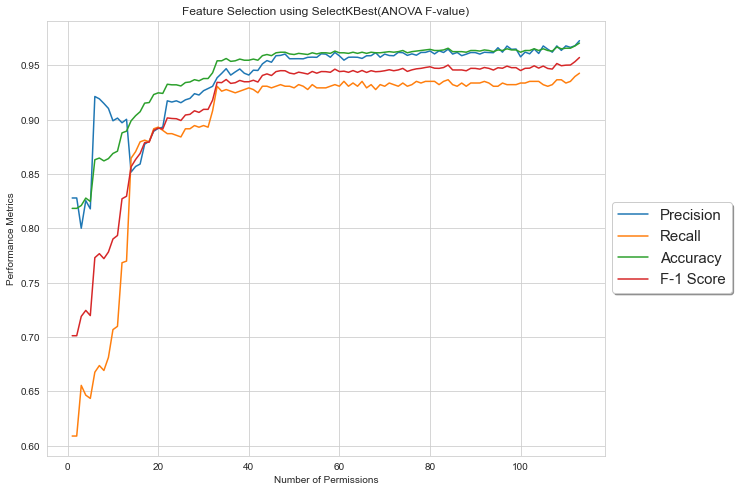

In [34]:
incremental_plot(1,114,title)

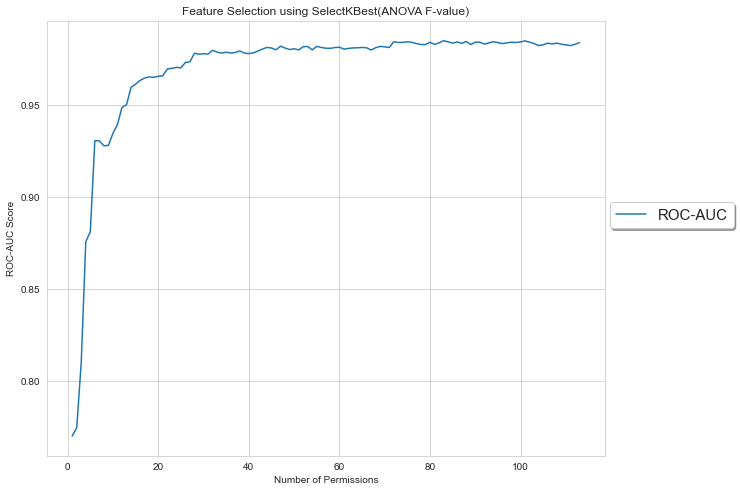

In [35]:
incremental_plot_auc(1,114,title)

In [69]:
X_top_feat_imps.shape

(7518, 113)

## Feature Importance (feature_importances_)

In [36]:
#RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_validate.columns)

In [37]:
clear_metrics()
#X_top_feat_imps
for index in range(1,114,1):
    top_permissions_indexes = []
    top_permissions_indexes = feat_importances.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_permissions_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7701   (+/- 0.0397)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7745   (+/- 0.0397)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8426   (+/- 0.0197)
Precision: 0.9539   (+/- 0.0197)
Recall: 0.5789   (+/- 0.0197)
F-1 Score: 0.7198   (+/- 0.0197)
ROC-AUC: 0.8611   (+/- 0.0197)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8426   (+/- 0.0197)
Precision: 0.9539   (+/- 0.0197)
Recall: 0.5789   (+/- 0.0197)
F-1 Score: 0.7198   (+/- 0.0197)
ROC-AUC: 0.9174   (+/- 0.0197)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8668   (+/- 0.0245)
Precision: 0.9415   (+/- 0.0245)
Recall: 0.6616   (+

Classification Report for Random Forest:    39
Accuracy: 0.9647   (+/- 0.0163)
Precision: 0.9632   (+/- 0.0163)
Recall: 0.9353   (+/- 0.0163)
F-1 Score: 0.9488   (+/- 0.0163)
ROC-AUC: 0.9829   (+/- 0.0163)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9663   (+/- 0.0143)
Precision: 0.9677   (+/- 0.0143)
Recall: 0.9353   (+/- 0.0143)
F-1 Score: 0.9510   (+/- 0.0143)
ROC-AUC: 0.9828   (+/- 0.0143)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9663   (+/- 0.0143)
Precision: 0.9693   (+/- 0.0143)
Recall: 0.9338   (+/- 0.0143)
F-1 Score: 0.9509   (+/- 0.0143)
ROC-AUC: 0.9837   (+/- 0.0143)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9632   (+/- 0.0141)
Precision: 0.9619   (+/- 0.0141)
Recall: 0.9323   (+/- 0.0141)
F-1 Score: 0.9465   (+/- 0.0141)
ROC-AUC: 0.9834   (+/- 0.0141)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9642   (+/- 0.0155)
Precision: 0.9645   (+/- 0.0155)
Recall: 0.9323   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9695   (+/- 0.0193)
Precision: 0.9742   (+/- 0.0193)
Recall: 0.9383   (+/- 0.0193)
F-1 Score: 0.9555   (+/- 0.0193)
ROC-AUC: 0.9836   (+/- 0.0193)
(1900, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9679   (+/- 0.0208)
Precision: 0.9710   (+/- 0.0208)
Recall: 0.9368   (+/- 0.0208)
F-1 Score: 0.9533   (+/- 0.0208)
ROC-AUC: 0.9827   (+/- 0.0208)
(1900, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9689   (+/- 0.0185)
Precision: 0.9740   (+/- 0.0185)
Recall: 0.9368   (+/- 0.0185)
F-1 Score: 0.9547   (+/- 0.0185)
ROC-AUC: 0.9832   (+/- 0.0185)
(1900, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9689   (+/- 0.0179)
Precision: 0.9726   (+/- 0.0179)
Recall: 0.9383   (+/- 0.0179)
F-1 Score: 0.9549   (+/- 0.0179)
ROC-AUC: 0.9826   (+/- 0.0179)
(1900, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9689   (+/- 0.0145)
Precision: 0.9741   (+/- 0.0145)
Recall: 0.9368   (+/

In [38]:
title = "Feature Selection using Random Forest Classifier - Feature Importances"
results_to_csv(title)

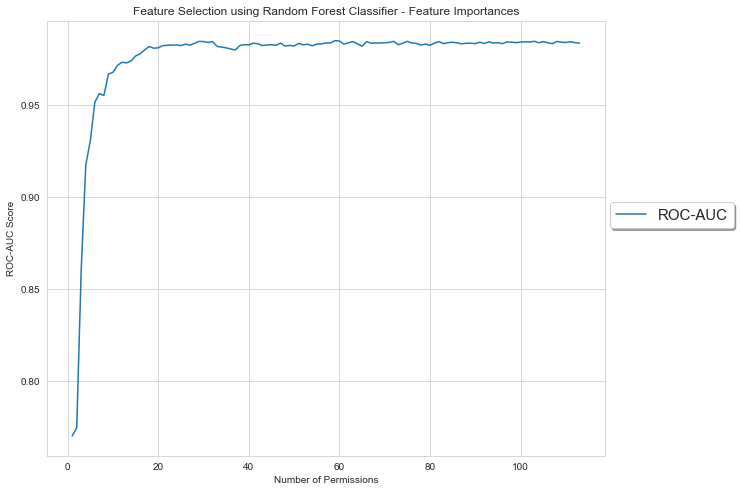

In [39]:
incremental_plot_auc(1,114, title)

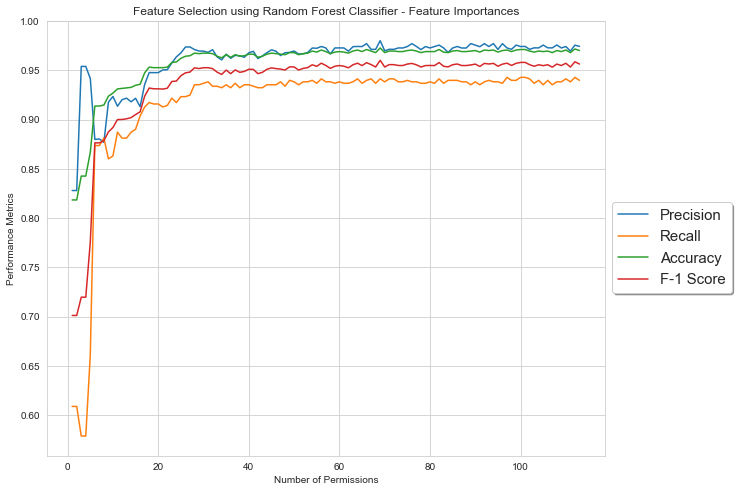

In [40]:
incremental_plot(1,114, title)


In [41]:
#ExtraTreeClassifier
model = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)

In [42]:
clear_metrics()
X_top_feat_imps
for index in range(1,114,1):
    top_permissions_indexes = []
    top_permissions_indexes = feat_importances.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_permissions_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7701   (+/- 0.0397)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7745   (+/- 0.0397)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8163   (+/- 0.0387)
Precision: 0.8267   (+/- 0.0387)
Recall: 0.6029   (+/- 0.0387)
F-1 Score: 0.6967   (+/- 0.0387)
ROC-AUC: 0.8479   (+/- 0.0387)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8426   (+/- 0.0197)
Precision: 0.9539   (+/- 0.0197)
Recall: 0.5789   (+/- 0.0197)
F-1 Score: 0.7198   (+/- 0.0197)
ROC-AUC: 0.9175   (+/- 0.0197)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8921   (+/- 0.0377)
Precision: 0.8849   (+/- 0.0377)
Recall: 0.7955   (+

Classification Report for Random Forest:    39
Accuracy: 0.9663   (+/- 0.0135)
Precision: 0.9676   (+/- 0.0135)
Recall: 0.9353   (+/- 0.0135)
F-1 Score: 0.9510   (+/- 0.0135)
ROC-AUC: 0.9835   (+/- 0.0135)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9653   (+/- 0.0158)
Precision: 0.9633   (+/- 0.0158)
Recall: 0.9368   (+/- 0.0158)
F-1 Score: 0.9496   (+/- 0.0158)
ROC-AUC: 0.9832   (+/- 0.0158)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9642   (+/- 0.0181)
Precision: 0.9634   (+/- 0.0181)
Recall: 0.9338   (+/- 0.0181)
F-1 Score: 0.9480   (+/- 0.0181)
ROC-AUC: 0.9832   (+/- 0.0181)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9658   (+/- 0.0184)
Precision: 0.9664   (+/- 0.0184)
Recall: 0.9353   (+/- 0.0184)
F-1 Score: 0.9503   (+/- 0.0184)
ROC-AUC: 0.9830   (+/- 0.0184)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9658   (+/- 0.0165)
Precision: 0.9692   (+/- 0.0165)
Recall: 0.9323   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9679   (+/- 0.0223)
Precision: 0.9681   (+/- 0.0223)
Recall: 0.9398   (+/- 0.0223)
F-1 Score: 0.9534   (+/- 0.0223)
ROC-AUC: 0.9829   (+/- 0.0223)
(1900, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9674   (+/- 0.0204)
Precision: 0.9699   (+/- 0.0204)
Recall: 0.9368   (+/- 0.0204)
F-1 Score: 0.9526   (+/- 0.0204)
ROC-AUC: 0.9846   (+/- 0.0204)
(1900, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9700   (+/- 0.0142)
Precision: 0.9770   (+/- 0.0142)
Recall: 0.9368   (+/- 0.0142)
F-1 Score: 0.9562   (+/- 0.0142)
ROC-AUC: 0.9853   (+/- 0.0142)
(1900, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9716   (+/- 0.0212)
Precision: 0.9756   (+/- 0.0212)
Recall: 0.9428   (+/- 0.0212)
F-1 Score: 0.9586   (+/- 0.0212)
ROC-AUC: 0.9841   (+/- 0.0212)
(1900, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9689   (+/- 0.0128)
Precision: 0.9740   (+/- 0.0128)
Recall: 0.9368   (+/

In [43]:
title = "Feature Selection using Extra Trees Classifier Feature - Importances"
results_to_csv(title)

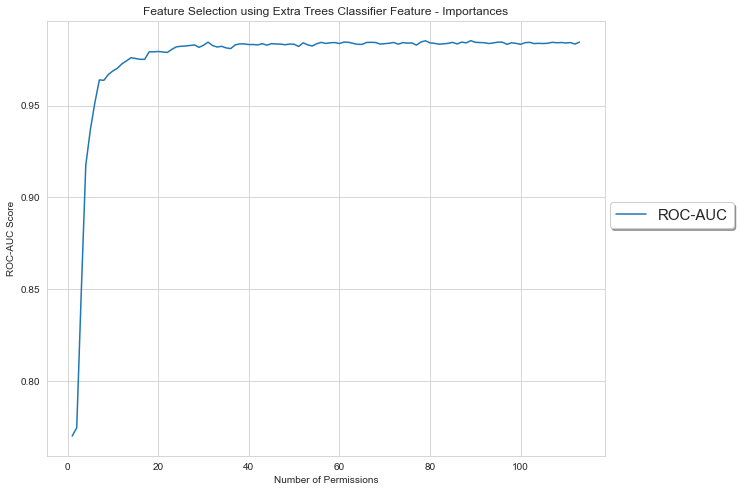

In [44]:
incremental_plot_auc(1,114, title)

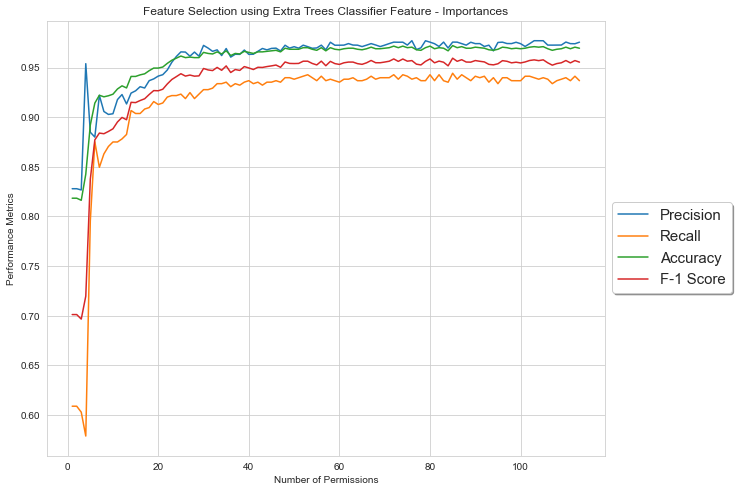

In [45]:
incremental_plot(1,114, title)


## Feature Selection Based on Mutual Information (Entropy) Gain

In [46]:
from sklearn.feature_selection import mutual_info_classif

In [47]:
mi = mutual_info_classif(X_train, y_train)

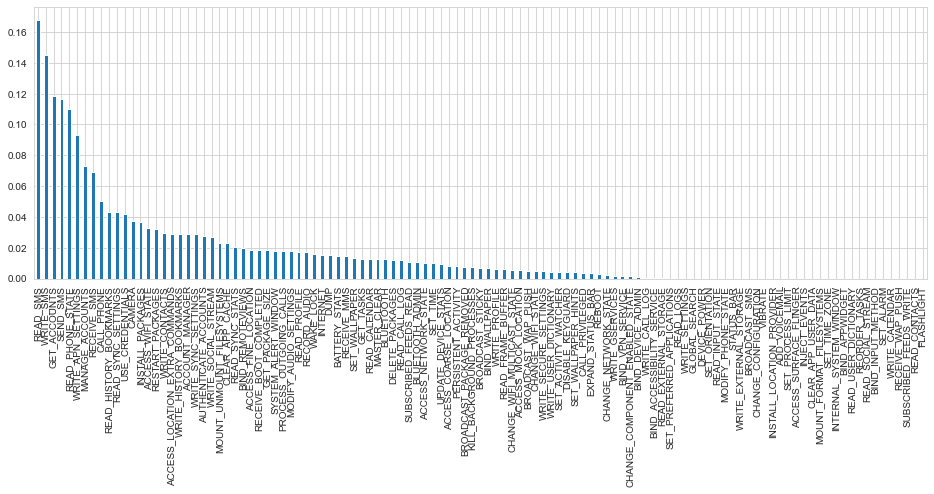

In [48]:
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)
mi.plot.bar(figsize = (16,5))

In [49]:
clear_metrics()
for index in range(1, 114,1):
    top_permissions_indexes = []
    top_permissions_indexes = mi.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_permissions_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7701   (+/- 0.0397)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7745   (+/- 0.0397)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8426   (+/- 0.0197)
Precision: 0.9539   (+/- 0.0197)
Recall: 0.5789   (+/- 0.0197)
F-1 Score: 0.7198   (+/- 0.0197)
ROC-AUC: 0.8611   (+/- 0.0197)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8679   (+/- 0.0218)
Precision: 0.9417   (+/- 0.0218)
Recall: 0.6646   (+/- 0.0218)
F-1 Score: 0.7783   (+/- 0.0218)
ROC-AUC: 0.8893   (+/- 0.0218)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8668   (+/- 0.0245)
Precision: 0.9415   (+/- 0.0245)
Recall: 0.6616   (+

Classification Report for Random Forest:    39
Accuracy: 0.9374   (+/- 0.0197)
Precision: 0.9247   (+/- 0.0197)
Recall: 0.8947   (+/- 0.0197)
F-1 Score: 0.9090   (+/- 0.0197)
ROC-AUC: 0.9748   (+/- 0.0197)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9363   (+/- 0.0202)
Precision: 0.9233   (+/- 0.0202)
Recall: 0.8931   (+/- 0.0202)
F-1 Score: 0.9074   (+/- 0.0202)
ROC-AUC: 0.9745   (+/- 0.0202)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9379   (+/- 0.0199)
Precision: 0.9238   (+/- 0.0199)
Recall: 0.8977   (+/- 0.0199)
F-1 Score: 0.9100   (+/- 0.0199)
ROC-AUC: 0.9748   (+/- 0.0199)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9405   (+/- 0.0183)
Precision: 0.9224   (+/- 0.0183)
Recall: 0.9068   (+/- 0.0183)
F-1 Score: 0.9142   (+/- 0.0183)
ROC-AUC: 0.9754   (+/- 0.0183)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9395   (+/- 0.0184)
Precision: 0.9209   (+/- 0.0184)
Recall: 0.9053   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9584   (+/- 0.0251)
Precision: 0.9546   (+/- 0.0251)
Recall: 0.9262   (+/- 0.0251)
F-1 Score: 0.9397   (+/- 0.0251)
ROC-AUC: 0.9813   (+/- 0.0251)
(1900, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9621   (+/- 0.0162)
Precision: 0.9648   (+/- 0.0162)
Recall: 0.9263   (+/- 0.0162)
F-1 Score: 0.9447   (+/- 0.0162)
ROC-AUC: 0.9815   (+/- 0.0162)
(1900, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9595   (+/- 0.0183)
Precision: 0.9586   (+/- 0.0183)
Recall: 0.9247   (+/- 0.0183)
F-1 Score: 0.9409   (+/- 0.0183)
ROC-AUC: 0.9814   (+/- 0.0183)
(1900, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9616   (+/- 0.0156)
Precision: 0.9633   (+/- 0.0156)
Recall: 0.9263   (+/- 0.0156)
F-1 Score: 0.9440   (+/- 0.0156)
ROC-AUC: 0.9806   (+/- 0.0156)
(1900, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9605   (+/- 0.0227)
Precision: 0.9618   (+/- 0.0227)
Recall: 0.9247   (+/

In [50]:
title = "Feature Selection using Mutual Information Gain (Entropy)"
results_to_csv(title)

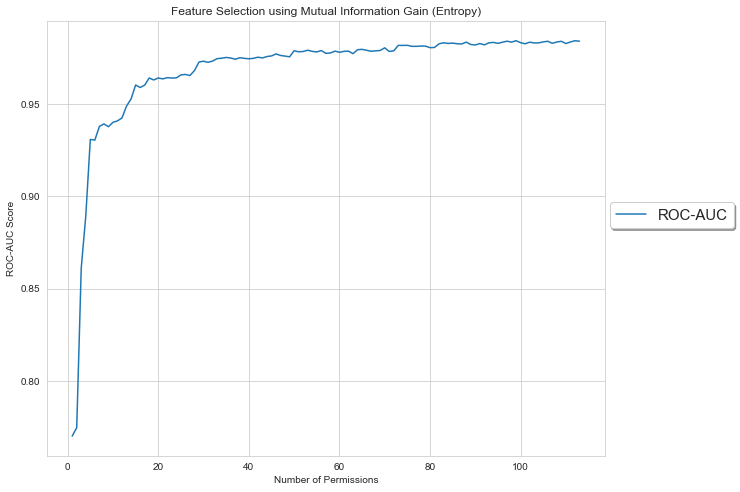

In [51]:
incremental_plot_auc(1,114, title)

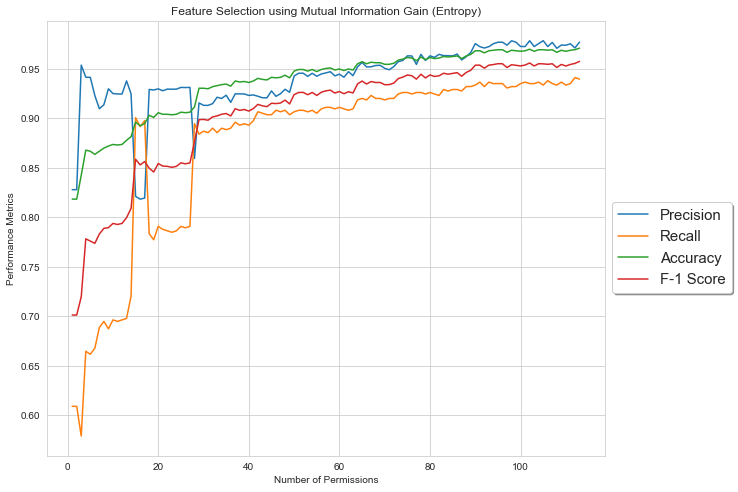

In [52]:
incremental_plot(1,114, title)


In [262]:
top_permissions_indexes = mi.nlargest(30).index
X_top_feat_imps = X.loc[:,top_permissions_indexes ]
print(X_top_feat_imps.shape)
run_randomForest(X_top_feat_imps,y_all, index)

(15036, 30)
Classification Report for Random Forest:    31
Accuracy: 0.9464   (+/- 0.0114)
Precision: 0.9571   (+/- 0.0114)
Recall: 0.8953   (+/- 0.0114)
F-1 Score: 0.9251   (+/- 0.0114)
ROC-AUC: 0.9863   (+/- 0.0114)


## Feature Selection Based on Univariate ROC_AUC for Classification

In [53]:
from sklearn.metrics import roc_auc_score

roc_auc = []
for feature in X_train.columns:
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train[feature].to_frame(), y_train)
    y_pred = clf.predict(X_validate[feature].to_frame())
    roc_auc.append(roc_auc_score(y_validate, y_pred))

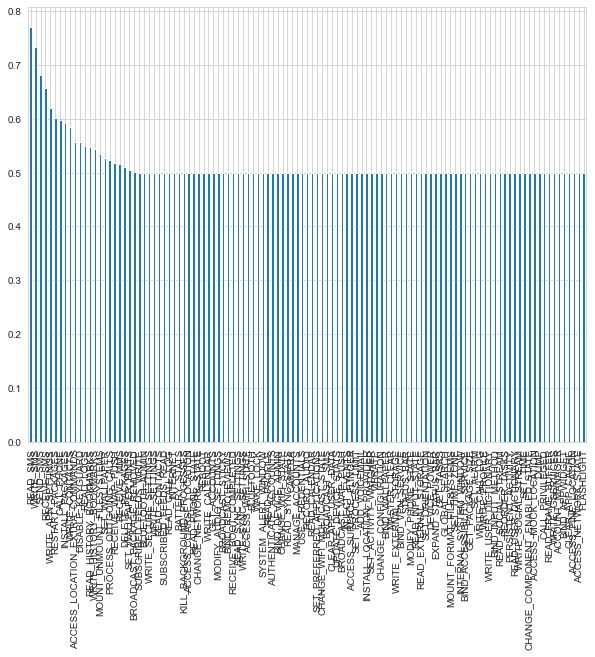

In [54]:
roc_values = pd.Series(roc_auc)
roc_values.index = X_train.columns
roc_values.sort_values(ascending =False, inplace = True)
roc_values.plot.bar()

In [55]:
sel = roc_values[roc_values>0.5]
X_roc_auc = X_train[sel.index]
X_roc_auc.shape

(1899, 22)

In [56]:
clear_metrics()
for index in range(1, len(sel)):
    top_permissions_indexes = []
    top_permissions_indexes = sel.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_permissions_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7701   (+/- 0.0397)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7745   (+/- 0.0397)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8211   (+/- 0.0588)
Precision: 0.8001   (+/- 0.0588)
Recall: 0.6555   (+/- 0.0588)
F-1 Score: 0.7190   (+/- 0.0588)
ROC-AUC: 0.8102   (+/- 0.0588)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8268   (+/- 0.0512)
Precision: 0.8284   (+/- 0.0512)
Recall: 0.6391   (+/- 0.0512)
F-1 Score: 0.7205   (+/- 0.0512)
ROC-AUC: 0.8146   (+/- 0.0512)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8211   (+/- 0.0466)
Precision: 0.8431   (+/- 0.0466)
Recall: 0.6030   (+

In [91]:
top_permissions_indexes = []
top_permissions_indexes = sel.nlargest(30).index
X_top_feat_imps = X.loc[:,top_permissions_indexes ]
print(X_top_feat_imps.shape)


NameError: name 'X' is not defined

In [ ]:
%%time 
run_randomForest(X_top_feat_imps,y_all, index)

In [57]:
title = "Feature Selection Based on Univariate ROC_AUC Score"
results_to_csv(title)

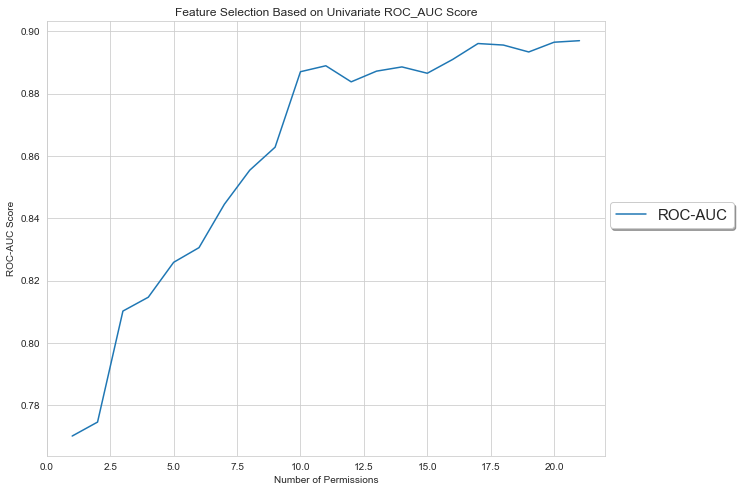

In [58]:
incremental_plot_auc(1,len(sel), title)

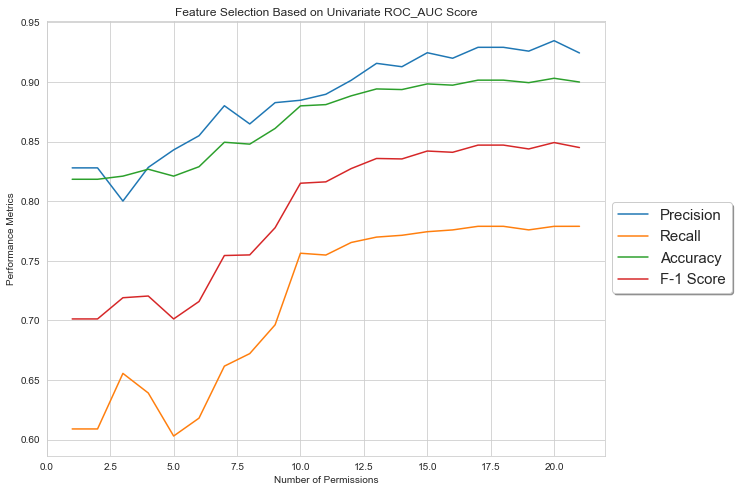

In [59]:
incremental_plot(1,len(sel), title)


## Feature Selection using Principal Component Analysis

In [60]:
clear_metrics()
for component in range(1,114):
    pca = PCA(n_components=component, random_state=0)
    pca.fit(X_train)
    X_pca_optimal = pca.transform(X_validate)
    print('Selected Components: ', component)
    run_randomForest(X_pca_optimal,y_validate,component)
    print()

Selected Components:  1
Classification Report for Random Forest:    1
Accuracy: 0.8500   (+/- 0.0424)
Precision: 0.7683   (+/- 0.0424)
Recall: 0.8211   (+/- 0.0424)
F-1 Score: 0.7930   (+/- 0.0424)
ROC-AUC: 0.8727   (+/- 0.0424)

Selected Components:  2
Classification Report for Random Forest:    2
Accuracy: 0.9205   (+/- 0.0276)
Precision: 0.8928   (+/- 0.0276)
Recall: 0.8796   (+/- 0.0276)
F-1 Score: 0.8852   (+/- 0.0276)
ROC-AUC: 0.9519   (+/- 0.0276)

Selected Components:  3
Classification Report for Random Forest:    3
Accuracy: 0.9563   (+/- 0.0211)
Precision: 0.9541   (+/- 0.0211)
Recall: 0.9202   (+/- 0.0211)
F-1 Score: 0.9364   (+/- 0.0211)
ROC-AUC: 0.9775   (+/- 0.0211)

Selected Components:  4
Classification Report for Random Forest:    4
Accuracy: 0.9526   (+/- 0.0211)
Precision: 0.9436   (+/- 0.0211)
Recall: 0.9202   (+/- 0.0211)
F-1 Score: 0.9314   (+/- 0.0211)
ROC-AUC: 0.9776   (+/- 0.0211)

Selected Components:  5
Classification Report for Random Forest:    5
Accuracy: 

Classification Report for Random Forest:    37
Accuracy: 0.9595   (+/- 0.0176)
Precision: 0.9759   (+/- 0.0176)
Recall: 0.9067   (+/- 0.0176)
F-1 Score: 0.9398   (+/- 0.0176)
ROC-AUC: 0.9817   (+/- 0.0176)

Selected Components:  38
Classification Report for Random Forest:    38
Accuracy: 0.9589   (+/- 0.0181)
Precision: 0.9776   (+/- 0.0181)
Recall: 0.9037   (+/- 0.0181)
F-1 Score: 0.9389   (+/- 0.0181)
ROC-AUC: 0.9816   (+/- 0.0181)

Selected Components:  39
Classification Report for Random Forest:    39
Accuracy: 0.9574   (+/- 0.0179)
Precision: 0.9792   (+/- 0.0179)
Recall: 0.8977   (+/- 0.0179)
F-1 Score: 0.9363   (+/- 0.0179)
ROC-AUC: 0.9799   (+/- 0.0179)

Selected Components:  40
Classification Report for Random Forest:    40
Accuracy: 0.9584   (+/- 0.0202)
Precision: 0.9764   (+/- 0.0202)
Recall: 0.9036   (+/- 0.0202)
F-1 Score: 0.9381   (+/- 0.0202)
ROC-AUC: 0.9805   (+/- 0.0202)

Selected Components:  41
Classification Report for Random Forest:    41
Accuracy: 0.9589   (+/- 0

Classification Report for Random Forest:    73
Accuracy: 0.9568   (+/- 0.0261)
Precision: 0.9854   (+/- 0.0261)
Recall: 0.8901   (+/- 0.0261)
F-1 Score: 0.9347   (+/- 0.0261)
ROC-AUC: 0.9815   (+/- 0.0261)

Selected Components:  74
Classification Report for Random Forest:    74
Accuracy: 0.9558   (+/- 0.0271)
Precision: 0.9837   (+/- 0.0271)
Recall: 0.8886   (+/- 0.0271)
F-1 Score: 0.9332   (+/- 0.0271)
ROC-AUC: 0.9813   (+/- 0.0271)

Selected Components:  75
Classification Report for Random Forest:    75
Accuracy: 0.9579   (+/- 0.0290)
Precision: 0.9884   (+/- 0.0290)
Recall: 0.8902   (+/- 0.0290)
F-1 Score: 0.9363   (+/- 0.0290)
ROC-AUC: 0.9817   (+/- 0.0290)

Selected Components:  76
Classification Report for Random Forest:    76
Accuracy: 0.9584   (+/- 0.0237)
Precision: 0.9853   (+/- 0.0237)
Recall: 0.8947   (+/- 0.0237)
F-1 Score: 0.9375   (+/- 0.0237)
ROC-AUC: 0.9816   (+/- 0.0237)

Selected Components:  77
Classification Report for Random Forest:    77
Accuracy: 0.9595   (+/- 0

Classification Report for Random Forest:    109
Accuracy: 0.9626   (+/- 0.0197)
Precision: 0.9903   (+/- 0.0197)
Recall: 0.9022   (+/- 0.0197)
F-1 Score: 0.9439   (+/- 0.0197)
ROC-AUC: 0.9814   (+/- 0.0197)

Selected Components:  110
Classification Report for Random Forest:    110
Accuracy: 0.9563   (+/- 0.0245)
Precision: 0.9886   (+/- 0.0245)
Recall: 0.8857   (+/- 0.0245)
F-1 Score: 0.9338   (+/- 0.0245)
ROC-AUC: 0.9813   (+/- 0.0245)

Selected Components:  111
Classification Report for Random Forest:    111
Accuracy: 0.9600   (+/- 0.0271)
Precision: 0.9885   (+/- 0.0271)
Recall: 0.8962   (+/- 0.0271)
F-1 Score: 0.9397   (+/- 0.0271)
ROC-AUC: 0.9810   (+/- 0.0271)

Selected Components:  112
Classification Report for Random Forest:    112
Accuracy: 0.9558   (+/- 0.0356)
Precision: 0.9881   (+/- 0.0356)
Recall: 0.8842   (+/- 0.0356)
F-1 Score: 0.9328   (+/- 0.0356)
ROC-AUC: 0.9817   (+/- 0.0356)

Selected Components:  113
Classification Report for Random Forest:    113
Accuracy: 0.9558

In [61]:
title = "Feature Selection using Principal Component Analysis"
results_to_csv(title)

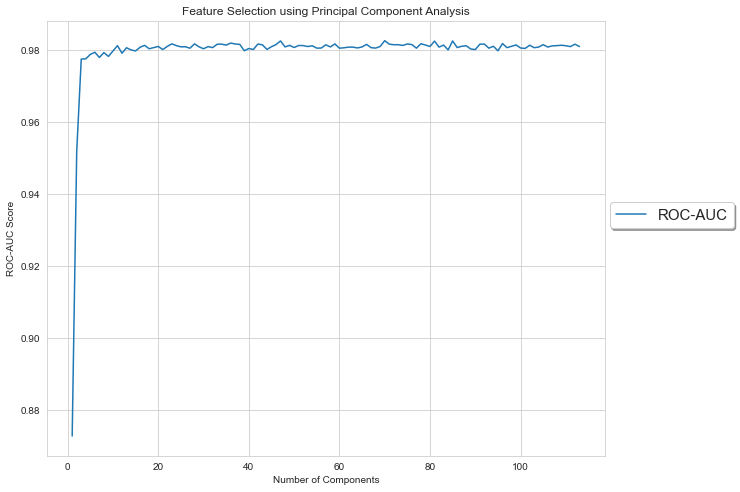

In [62]:
incremental_plot_auc(1,114, title, "Number of Components")

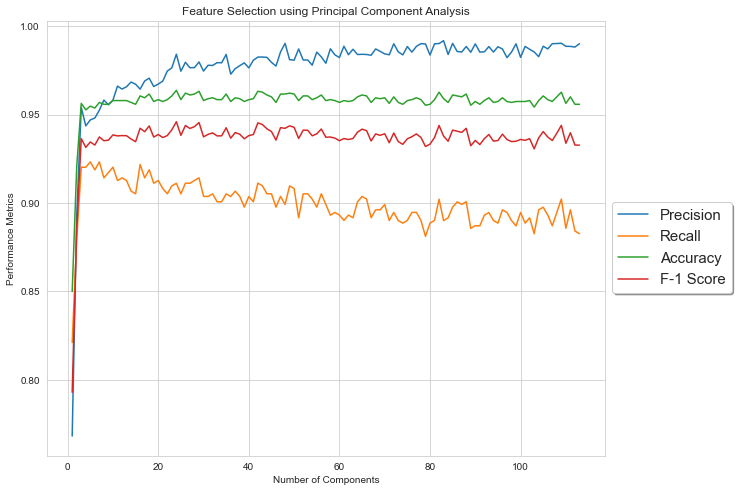

In [63]:
incremental_plot(1,114, title, "Number of Components")


## Feature Selection using RFE (RandomForestClassifier)

In [64]:
#best RFE(RandomForestClassifier) features
clear_metrics()
for index in range(1, 114):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select=index)
    sel.fit(X_train, y_train)
    X_transform = sel.transform(X_validate)
    print(X_transform.shape)
    print('Selected Feature: ', index)
    run_randomForest(X_transform, y_validate, index)

(1900, 1)
Selected Feature:  1
Classification Report for Random Forest:    1
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7701   (+/- 0.0397)
(1900, 2)
Selected Feature:  2
Classification Report for Random Forest:    2
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7745   (+/- 0.0397)
(1900, 3)
Selected Feature:  3
Classification Report for Random Forest:    3
Accuracy: 0.8426   (+/- 0.0197)
Precision: 0.9539   (+/- 0.0197)
Recall: 0.5789   (+/- 0.0197)
F-1 Score: 0.7198   (+/- 0.0197)
ROC-AUC: 0.8611   (+/- 0.0197)
(1900, 4)
Selected Feature:  4
Classification Report for Random Forest:    4
Accuracy: 0.8679   (+/- 0.0218)
Precision: 0.9417   (+/- 0.0218)
Recall: 0.6646   (+/- 0.0218)
F-1 Score: 0.7783   (+/- 0.0218)
ROC-AUC: 0.8893   (+/- 0.0218)
(1900, 5)
Selected Feature:  5
Classification Report for

(1900, 36)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9621   (+/- 0.0209)
Precision: 0.9576   (+/- 0.0209)
Recall: 0.9338   (+/- 0.0209)
F-1 Score: 0.9451   (+/- 0.0209)
ROC-AUC: 0.9807   (+/- 0.0209)
(1900, 37)
Selected Feature:  37
Classification Report for Random Forest:    37
Accuracy: 0.9632   (+/- 0.0182)
Precision: 0.9618   (+/- 0.0182)
Recall: 0.9323   (+/- 0.0182)
F-1 Score: 0.9465   (+/- 0.0182)
ROC-AUC: 0.9801   (+/- 0.0182)
(1900, 38)
Selected Feature:  38
Classification Report for Random Forest:    38
Accuracy: 0.9658   (+/- 0.0158)
Precision: 0.9678   (+/- 0.0158)
Recall: 0.9338   (+/- 0.0158)
F-1 Score: 0.9502   (+/- 0.0158)
ROC-AUC: 0.9808   (+/- 0.0158)
(1900, 39)
Selected Feature:  39
Classification Report for Random Forest:    39
Accuracy: 0.9647   (+/- 0.0194)
Precision: 0.9649   (+/- 0.0194)
Recall: 0.9338   (+/- 0.0194)
F-1 Score: 0.9487   (+/- 0.0194)
ROC-AUC: 0.9815   (+/- 0.0194)
(1900, 40)
Selected Feature:  40
Classificat

D:\Galib\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Classification Report for Random Forest:    65
Accuracy: 0.9705   (+/- 0.0212)
Precision: 0.9756   (+/- 0.0212)
Recall: 0.9398   (+/- 0.0212)
F-1 Score: 0.9570   (+/- 0.0212)
ROC-AUC: 0.9840   (+/- 0.0212)
(1900, 66)
Selected Feature:  66
Classification Report for Random Forest:    66
Accuracy: 0.9711   (+/- 0.0190)
Precision: 0.9770   (+/- 0.0190)
Recall: 0.9398   (+/- 0.0190)
F-1 Score: 0.9578   (+/- 0.0190)
ROC-AUC: 0.9850   (+/- 0.0190)
(1900, 67)
Selected Feature:  67
Classification Report for Random Forest:    67
Accuracy: 0.9689   (+/- 0.0191)
Precision: 0.9741   (+/- 0.0191)
Recall: 0.9368   (+/- 0.0191)
F-1 Score: 0.9547   (+/- 0.0191)
ROC-AUC: 0.9837   (+/- 0.0191)
(1900, 68)
Selected Feature:  68
Classification Report for Random Forest:    68
Accuracy: 0.9684   (+/- 0.0200)
Precision: 0.9698   (+/- 0.0200)
Recall: 0.9398   (+/- 0.0200)
F-1 Score: 0.9542   (+/- 0.0200)
ROC-AUC: 0.9843   (+/- 0.0200)
(1900, 69)
Selected Feature:  69
Classification Report for Random Forest:    

(1900, 100)
Selected Feature:  100
Classification Report for Random Forest:    100
Accuracy: 0.9674   (+/- 0.0215)
Precision: 0.9666   (+/- 0.0215)
Recall: 0.9397   (+/- 0.0215)
F-1 Score: 0.9526   (+/- 0.0215)
ROC-AUC: 0.9845   (+/- 0.0215)
(1900, 101)
Selected Feature:  101
Classification Report for Random Forest:    101
Accuracy: 0.9674   (+/- 0.0147)
Precision: 0.9696   (+/- 0.0147)
Recall: 0.9368   (+/- 0.0147)
F-1 Score: 0.9526   (+/- 0.0147)
ROC-AUC: 0.9852   (+/- 0.0147)
(1900, 102)
Selected Feature:  102
Classification Report for Random Forest:    102
Accuracy: 0.9679   (+/- 0.0191)
Precision: 0.9697   (+/- 0.0191)
Recall: 0.9383   (+/- 0.0191)
F-1 Score: 0.9534   (+/- 0.0191)
ROC-AUC: 0.9848   (+/- 0.0191)
(1900, 103)
Selected Feature:  103
Classification Report for Random Forest:    103
Accuracy: 0.9695   (+/- 0.0209)
Precision: 0.9756   (+/- 0.0209)
Recall: 0.9368   (+/- 0.0209)
F-1 Score: 0.9554   (+/- 0.0209)
ROC-AUC: 0.9842   (+/- 0.0209)
(1900, 104)
Selected Feature:  1

In [65]:
title = "Recursive Feature Elimination (RFE) using Random Forest Classifier"
results_to_csv(title)

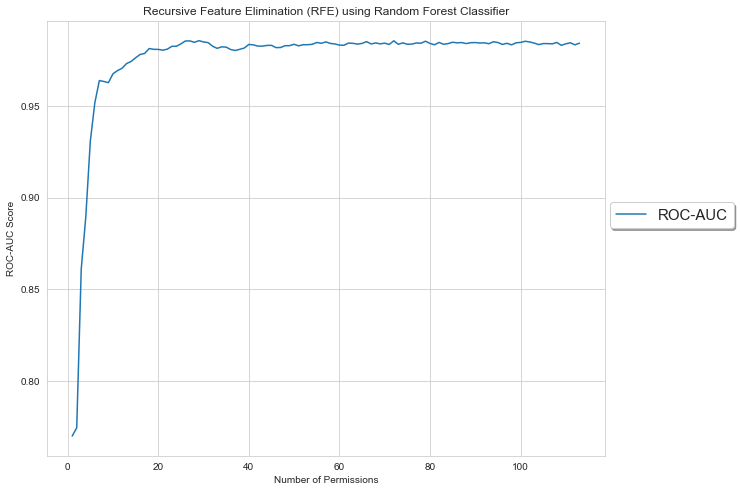

In [66]:
incremental_plot_auc(1,114, title)

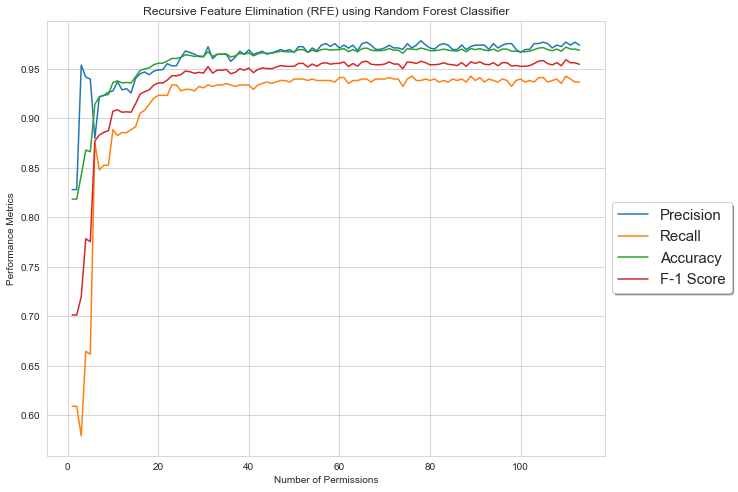

In [67]:
incremental_plot(1,114, title)


In [68]:
#best RFE(Gradient BoostingClassifier) features
clear_metrics()
for index in range(1, 114):
    sel = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0), n_features_to_select = index)
    sel.fit(X_train,y_train)
    X_optimal_gradient = sel.transform(X_validate)
    print(X_optimal_gradient.shape)
    print('Selected Feature: ', index)
    run_randomForest(X_optimal_gradient,y_validate, index)

(1900, 1)
Selected Feature:  1
Classification Report for Random Forest:    1
Accuracy: 0.8184   (+/- 0.0397)
Precision: 0.8280   (+/- 0.0397)
Recall: 0.6089   (+/- 0.0397)
F-1 Score: 0.7012   (+/- 0.0397)
ROC-AUC: 0.7701   (+/- 0.0397)
(1900, 2)
Selected Feature:  2
Classification Report for Random Forest:    2
Accuracy: 0.8432   (+/- 0.0199)
Precision: 0.9562   (+/- 0.0199)
Recall: 0.5789   (+/- 0.0199)
F-1 Score: 0.7204   (+/- 0.0199)
ROC-AUC: 0.8579   (+/- 0.0199)
(1900, 3)
Selected Feature:  3
Classification Report for Random Forest:    3
Accuracy: 0.8779   (+/- 0.0339)
Precision: 0.8595   (+/- 0.0339)
Recall: 0.7790   (+/- 0.0339)
F-1 Score: 0.8170   (+/- 0.0339)
ROC-AUC: 0.9102   (+/- 0.0339)
(1900, 4)
Selected Feature:  4
Classification Report for Random Forest:    4
Accuracy: 0.8921   (+/- 0.0324)
Precision: 0.9055   (+/- 0.0324)
Recall: 0.7728   (+/- 0.0324)
F-1 Score: 0.8335   (+/- 0.0324)
ROC-AUC: 0.9265   (+/- 0.0324)
(1900, 5)
Selected Feature:  5
Classification Report for

(1900, 36)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9642   (+/- 0.0274)
Precision: 0.9637   (+/- 0.0274)
Recall: 0.9337   (+/- 0.0274)
F-1 Score: 0.9480   (+/- 0.0274)
ROC-AUC: 0.9815   (+/- 0.0274)
(1900, 37)
Selected Feature:  37
Classification Report for Random Forest:    37
Accuracy: 0.9663   (+/- 0.0227)
Precision: 0.9681   (+/- 0.0227)
Recall: 0.9353   (+/- 0.0227)
F-1 Score: 0.9510   (+/- 0.0227)
ROC-AUC: 0.9839   (+/- 0.0227)
(1900, 38)
Selected Feature:  38
Classification Report for Random Forest:    38
Accuracy: 0.9653   (+/- 0.0241)
Precision: 0.9649   (+/- 0.0241)
Recall: 0.9352   (+/- 0.0241)
F-1 Score: 0.9495   (+/- 0.0241)
ROC-AUC: 0.9825   (+/- 0.0241)
(1900, 39)
Selected Feature:  39
Classification Report for Random Forest:    39
Accuracy: 0.9658   (+/- 0.0255)
Precision: 0.9666   (+/- 0.0255)
Recall: 0.9353   (+/- 0.0255)
F-1 Score: 0.9503   (+/- 0.0255)
ROC-AUC: 0.9833   (+/- 0.0255)
(1900, 40)
Selected Feature:  40
Classificat

(1900, 71)
Selected Feature:  71
Classification Report for Random Forest:    71
Accuracy: 0.9679   (+/- 0.0202)
Precision: 0.9741   (+/- 0.0202)
Recall: 0.9337   (+/- 0.0202)
F-1 Score: 0.9531   (+/- 0.0202)
ROC-AUC: 0.9836   (+/- 0.0202)
(1900, 72)
Selected Feature:  72
Classification Report for Random Forest:    72
Accuracy: 0.9705   (+/- 0.0143)
Precision: 0.9771   (+/- 0.0143)
Recall: 0.9383   (+/- 0.0143)
F-1 Score: 0.9570   (+/- 0.0143)
ROC-AUC: 0.9841   (+/- 0.0143)
(1900, 73)
Selected Feature:  73
Classification Report for Random Forest:    73
Accuracy: 0.9705   (+/- 0.0171)
Precision: 0.9755   (+/- 0.0171)
Recall: 0.9398   (+/- 0.0171)
F-1 Score: 0.9570   (+/- 0.0171)
ROC-AUC: 0.9833   (+/- 0.0171)
(1900, 74)
Selected Feature:  74
Classification Report for Random Forest:    74
Accuracy: 0.9679   (+/- 0.0166)
Precision: 0.9727   (+/- 0.0166)
Recall: 0.9353   (+/- 0.0166)
F-1 Score: 0.9532   (+/- 0.0166)
ROC-AUC: 0.9842   (+/- 0.0166)
(1900, 75)
Selected Feature:  75
Classificat

(1900, 106)
Selected Feature:  106
Classification Report for Random Forest:    106
Accuracy: 0.9705   (+/- 0.0195)
Precision: 0.9740   (+/- 0.0195)
Recall: 0.9413   (+/- 0.0195)
F-1 Score: 0.9570   (+/- 0.0195)
ROC-AUC: 0.9843   (+/- 0.0195)
(1900, 107)
Selected Feature:  107
Classification Report for Random Forest:    107
Accuracy: 0.9679   (+/- 0.0208)
Precision: 0.9698   (+/- 0.0208)
Recall: 0.9382   (+/- 0.0208)
F-1 Score: 0.9533   (+/- 0.0208)
ROC-AUC: 0.9840   (+/- 0.0208)
(1900, 108)
Selected Feature:  108
Classification Report for Random Forest:    108
Accuracy: 0.9668   (+/- 0.0134)
Precision: 0.9710   (+/- 0.0134)
Recall: 0.9337   (+/- 0.0134)
F-1 Score: 0.9516   (+/- 0.0134)
ROC-AUC: 0.9841   (+/- 0.0134)
(1900, 109)
Selected Feature:  109
Classification Report for Random Forest:    109
Accuracy: 0.9684   (+/- 0.0176)
Precision: 0.9712   (+/- 0.0176)
Recall: 0.9382   (+/- 0.0176)
F-1 Score: 0.9540   (+/- 0.0176)
ROC-AUC: 0.9840   (+/- 0.0176)
(1900, 110)
Selected Feature:  1

In [69]:
title = "Recursive Feature Elimination (RFE) using Gradient Boosting Classifier"
results_to_csv(title)

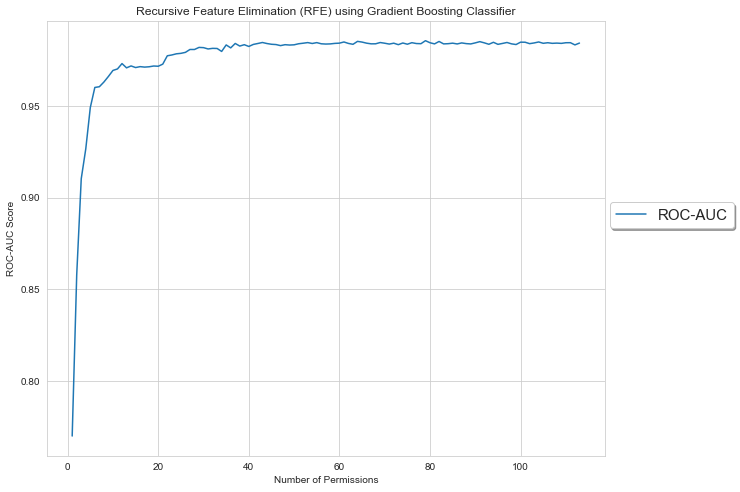

In [70]:
incremental_plot_auc(1,114, title)

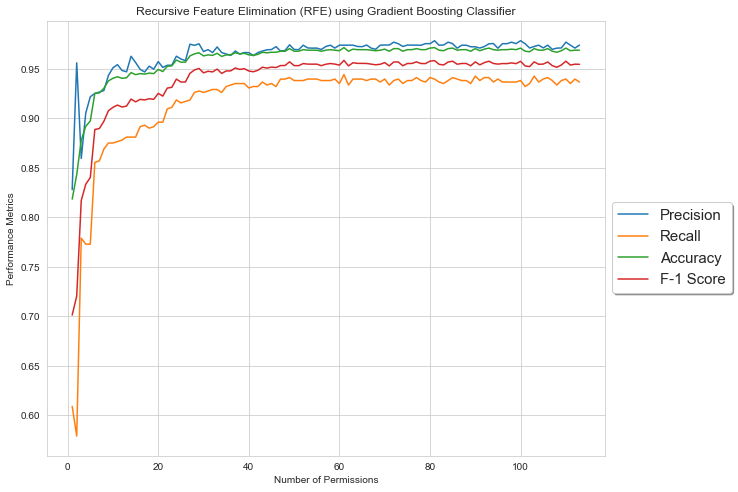

In [71]:
incremental_plot(1,114, title)



# Classifiers Evaluation

## For All Features

In [34]:
start = time.time()
run_randomForest(X_all, y_all)
end = time.time()
print(end - start)

Classification Report for Random Forest:    0
Accuracy: 0.9891   (+/- 0.0055)
Precision: 0.9931   (+/- 0.0055)
Recall: 0.9773   (+/- 0.0055)
F-1 Score: 0.9851   (+/- 0.0055)
ROC-AUC: 0.9988   (+/- 0.0055)
7.318322658538818


In [109]:
%%time
run_randomForest(X_all, y_all)

Classification Report for Random Forest:    0
Accuracy: 0.9891   (+/- 0.0055)
Precision: 0.9931   (+/- 0.0055)
Recall: 0.9773   (+/- 0.0055)
F-1 Score: 0.9851   (+/- 0.0055)
ROC-AUC: 0.9988   (+/- 0.0055)
CPU times: user 76.1 ms, sys: 68.2 ms, total: 144 ms
Wall time: 9 s


## For All Permissions

In [35]:
start = time.time()
run_randomForest(X_permissions, y_all)
end = time.time()
print(end - start)

Classification Report for Random Forest:    0
Accuracy: 0.9648   (+/- 0.0056)
Precision: 0.9703   (+/- 0.0056)
Recall: 0.9333   (+/- 0.0056)
F-1 Score: 0.9514   (+/- 0.0056)
ROC-AUC: 0.9911   (+/- 0.0056)
7.59743332862854


In [17]:
%%time
run_randomForest(X_permissions, y_all)

Classification Report for Random Forest:    0
Accuracy: 0.9648   (+/- 0.0056)
Precision: 0.9703   (+/- 0.0056)
Recall: 0.9333   (+/- 0.0056)
F-1 Score: 0.9514   (+/- 0.0056)
ROC-AUC: 0.9911   (+/- 0.0056)
CPU times: user 54.8 ms, sys: 41.5 ms, total: 96.3 ms
Wall time: 8.4 s


## For All API Calls

In [33]:
start = time.time()
run_randomForest(X_permissions, y_all)
end = time.time()
print(end - start)

Classification Report for Random Forest:    0
Accuracy: 0.9808   (+/- 0.0076)
Precision: 0.9862   (+/- 0.0076)
Recall: 0.9617   (+/- 0.0076)
F-1 Score: 0.9738   (+/- 0.0076)
ROC-AUC: 0.9963   (+/- 0.0076)
5.439223051071167


In [50]:
%%time
run_randomForest(X_permissions, y_all)

Classification Report for Random Forest:    0
Accuracy: 0.9808   (+/- 0.0076)
Precision: 0.9862   (+/- 0.0076)
Recall: 0.9617   (+/- 0.0076)
F-1 Score: 0.9738   (+/- 0.0076)
ROC-AUC: 0.9963   (+/- 0.0076)
CPU times: user 66.3 ms, sys: 7.84 ms, total: 74.2 ms
Wall time: 6.31 s


## Recursive Feature Elimination (RFE) using Random Forest Classifier

### Significant Permissions Identification

In [24]:
clear_metrics()

In [19]:
index =38

In [21]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X_permissions, y_all, test_size = 0.5, random_state = 0)


In [22]:
X_permissions.shape

(3799, 113)

In [23]:
X_train.shape

(1899, 113)

In [66]:
import time

clear_metrics()
#X_top_feat_imps
for index in range(23,28,1):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select=index)
    sel.fit(X_train, y_train)
    X_transform = sel.transform(X_validate)
#     print(X_transform.shape)
    X_corr_optimal = grouped_correlated(to_dataframe(X_transform))
#     print(X_corr_optimal.shape)
    print('Selected Feature: ', index)
    start = time.time()
    run_randomForest(X_corr_optimal, y_validate, index, with_corr=X_corr_optimal.shape[1])
    end = time.time()
    print(end - start)

(1900, 23)
(1900, 22)
Selected Feature:  23
Classification Report for Random Forest:    23
Accuracy: 0.9589   (+/- 0.0140)
Precision: 0.9498   (+/- 0.0140)
Recall: 0.9323   (+/- 0.0140)
F-1 Score: 0.9408   (+/- 0.0140)
ROC-AUC: 0.9831   (+/- 0.0140)
2.7832038402557373
(1900, 24)
(1900, 23)
Selected Feature:  24
Classification Report for Random Forest:    24
Accuracy: 0.9605   (+/- 0.0158)
Precision: 0.9544   (+/- 0.0158)
Recall: 0.9323   (+/- 0.0158)
F-1 Score: 0.9429   (+/- 0.0158)
ROC-AUC: 0.9823   (+/- 0.0158)
0.665196418762207
(1900, 25)
(1900, 24)
Selected Feature:  25
Classification Report for Random Forest:    25
Accuracy: 0.9632   (+/- 0.0141)
Precision: 0.9633   (+/- 0.0141)
Recall: 0.9308   (+/- 0.0141)
F-1 Score: 0.9465   (+/- 0.0141)
ROC-AUC: 0.9850   (+/- 0.0141)
0.6280770301818848
(1900, 26)
(1900, 25)
Selected Feature:  26
Classification Report for Random Forest:    26
Accuracy: 0.9653   (+/- 0.0135)
Precision: 0.9682   (+/- 0.0135)
Recall: 0.9323   (+/- 0.0135)
F-1 Scor

In [49]:
parent_dir = os.getcwd()
print(parent_dir)

D:\Galib\MS_Thesis_Desktop\MS_Thesis\Android Malware Analysis\Malgenome


In [39]:
without_corr, with_corr, acc, pre, rec, fs, auc

([35, 36, 37],
 [33, 34, 35],
 [0.9763095403416193, 0.9763102346896264, 0.9755207610054161],
 [0.979626933851544, 0.9788232666963387, 0.9788559178553145],
 [0.9484126984126984, 0.9492063492063492, 0.9468253968253968],
 [0.9636607706816396, 0.9637069998030217, 0.9624578711265404],
 [0.9880301832330247, 0.9883887105514972, 0.9887806514304287])

In [58]:
title = "RFE using Random Forest Classifier with Correlation-Based Elimination"
results_to_csv(title,corr=1)

D:\Galib\MS_Thesis_Desktop\MS_Thesis\Android Malware Analysis\Malgenome
1
[23, 24, 25, 26, 27] [22, 23, 24, 25, 26] [0.9657825302041383, 0.9673614775725594, 0.9668351617830858, 0.9692049715317317, 0.9697305929731982] [0.9560268987883296, 0.960531182978762, 0.963400426088711, 0.9662196865383665, 0.9662824689410773] [0.9404761904761905, 0.9404761904761905, 0.9357142857142857, 0.9404761904761905, 0.942063492063492] [0.9480357994917868, 0.9503082186020443, 0.9492735424416289, 0.9529989248579442, 0.9538240315286977] [0.9863448887070934, 0.9864059297429719, 0.9888172884021909, 0.9891098160654821, 0.98934502628871]


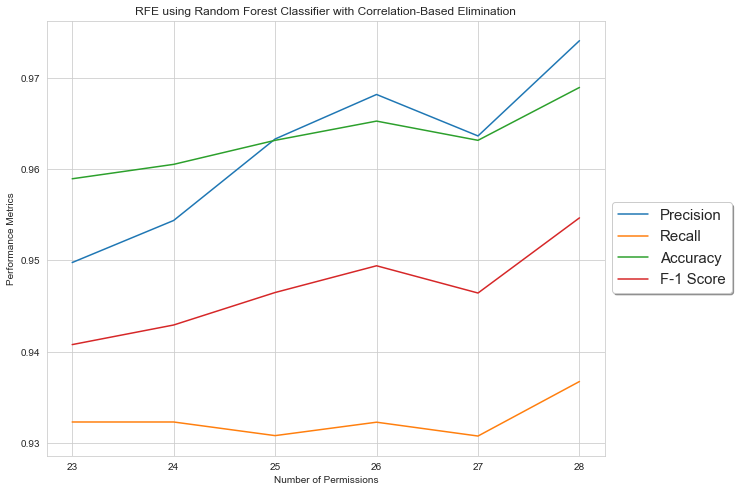

In [71]:
incremental_plot(23,29,title)

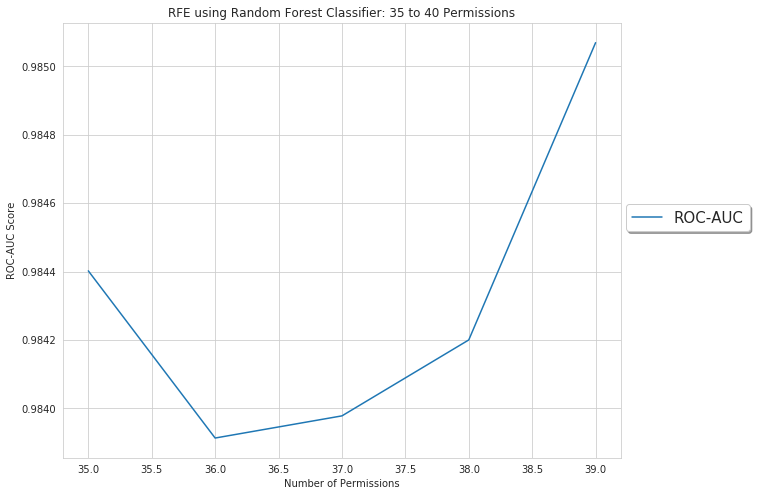

In [39]:
incremental_plot_auc(35,40,title)

In [67]:
%%time
sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, 
                    n_jobs=-1), n_features_to_select=113)
    
sel.fit(X_train,y_train)
X_optimal_permission = sel.transform(X_validate)
print(X_optimal_permission.shape)

(1900, 113)
Wall time: 172 ms


In [68]:
%%time
#print('Selected Feature: ', index)
run_randomForest(X_optimal_permission,y_validate, 113)

Classification Report for Random Forest:    113
Accuracy: 0.9689   (+/- 0.0152)
Precision: 0.9741   (+/- 0.0152)
Recall: 0.9367   (+/- 0.0152)
F-1 Score: 0.9547   (+/- 0.0152)
ROC-AUC: 0.9842   (+/- 0.0152)
Wall time: 839 ms


In [168]:
%%time
#print('Selected Feature: ', index)
run_randomForest(X_corr_optimal,y_all, index)

Classification Report for Random Forest:    32
Accuracy: 0.9862   (+/- 0.0082)
Precision: 0.9889   (+/- 0.0082)
Recall: 0.9736   (+/- 0.0082)
F-1 Score: 0.9811   (+/- 0.0082)
ROC-AUC: 0.9983   (+/- 0.0082)
CPU times: user 86.4 ms, sys: 85.4 ms, total: 172 ms
Wall time: 7.06 s


### List of Significant permissions and Permissions

In [178]:
X_top_permissions = to_dataframe(X_optimal_permission)
X_top_permissions

(15036, 38)


,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,1,1
5,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15032,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
15033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
15034,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
15035,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,1,1,1


In [180]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':sel.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
0,SEND_SMS,1
24,BROADCAST_STICKY,1
25,WAKE_LOCK,1
26,RECEIVE_BOOT_COMPLETED,1
61,WRITE_SETTINGS,1
...,...,...
82,BIND_TEXT_SERVICE,72
96,BIND_VPN_SERVICE,73
94,SET_ACTIVITY_WATCHER,74
60,WRITE_SOCIAL_STREAM,75


In [181]:
with open('top_malgenome_permissions.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Feature','Ranking'])
        writer.writerows(zip(selected_rfe_features.Feature, selected_rfe_features.Ranking))